# Kaggle competition

This notebook is based on the fast ai 1.0 framework and all the concepts are from  Jeremy Howard lessons 3 and  6. 

Besides a big thank you to Jeremy, I all so want to thank the creators of the following Kernels.

https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai (very nice and detailed description)

https://www.kaggle.com/suicaokhoailang/wip-densenet121-baseline-with-fastai


https://www.kaggle.com/guntherthepenguin/fastai-v1-pretrained-resnet-with-focalloss



##Dataset

We will use Kaggle's version of the PCam (PatchCamelyon) dataset. It's part of the Histopathologic Cancer Detection competition where the challenge is to identify metastatic tissue in histopathologic scans of lymph node sections.

The dataset consists of 220,025 image patches of size 96x96 (130,908 Metastatic negative and 89,117 Metastatic positive).


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['models', 'train_labels.csv', 'sample_submission.csv', 'all', 'all.zip', 'test', 'train', 'test.csv', 'train.csv', 'embeddings.zip']


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import random
from sklearn.utils import shuffle

from fastai import *
from fastai.vision import *





In [3]:
import fastai
print(fastai.__version__)

1.0.39


# Read the Data

In [4]:

path_input = '../input/' #kaggle structure
train_path = f'{path_input}train'
test_path = f'{path_input}test'
subm_path = Path('../submission/')
df = pd.read_csv(f'{path_input}/train_labels.csv')




In [5]:
# quick look at the label stats
df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
id       220025 non-null object
label    220025 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


# Show Data

In [8]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

ce92b76a938c75eff16b562c453cf7e08aff844e
3cacee699390455a9aea209b92c7d01ba69c81bc
8f6640e69c2cb1c4e00458a73c249b81c65c6192
c26938a9e6d1590c6499162f4704799dcab533fb
c4954730c6e3617b6160ab65d56c29063e1941a0


Text(0, 0.5, 'Tumor tissue samples')

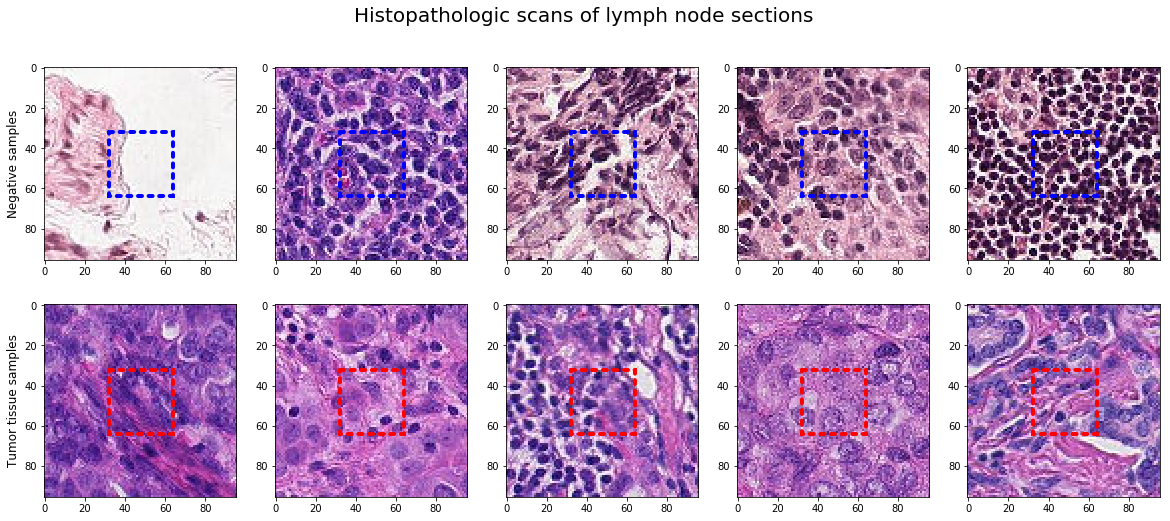

In [9]:
# random sampling
shuffled_data = shuffle(df)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    print(idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

# Domain information

If you want some background information about this domain. Please take a look at theses pages.

https://camelyon17.grand-challenge.org/Background/

https://academic.oup.com/gigascience/article/7/6/giy065/5026175


# Data augmentation

In [10]:
tfms = get_transforms(flip_vert=True, max_rotate=1., max_zoom=.2,  max_lighting=0.10, max_warp=0.  )

In [11]:
np.random.seed(42)
src = (ImageItemList.from_csv(path=path_input, csv_name='train_labels.csv', folder='train', suffix='.tif')
       .random_split_by_pct(0.1)
       .label_from_df(cols='label'))     

In [12]:
bs = 64

data =  (src.transform(tfms, size=96)
         .add_test_folder('test')
       .databunch(bs=bs).normalize(imagenet_stats)
       )

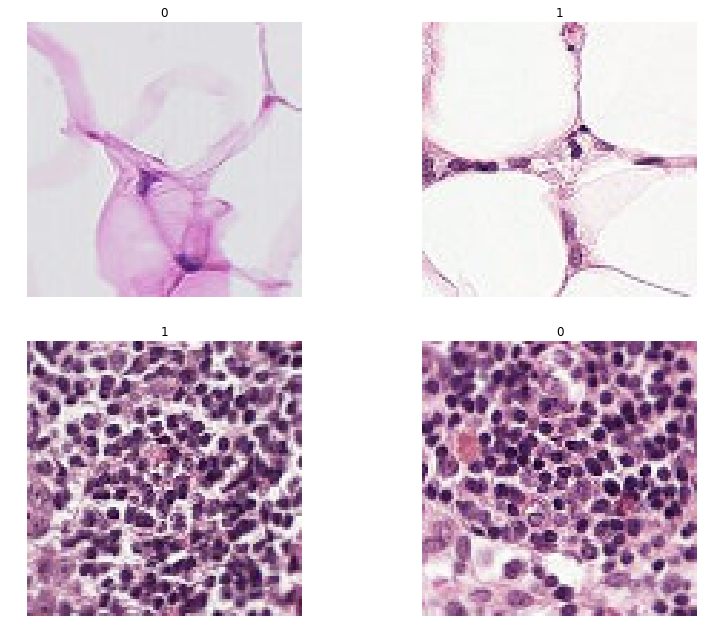

In [13]:
data.show_batch(rows=2, figsize=(12,9))

In [14]:
data.classes, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

([0, 1], 198023, 22002, 57458)

In [15]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

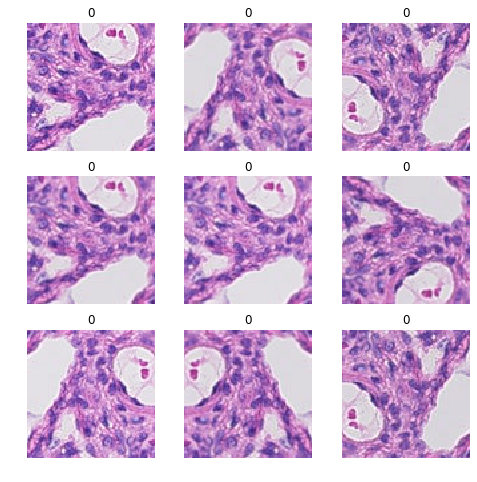

In [16]:
plot_multi(_plot, 3, 3, figsize=(8,8)) #transform results

# Train model

In [17]:
from torchvision.models import densenet161

In [18]:
arch = densenet161
model_name = 'densenet161' 


In [19]:
f1= FBeta() 

In [26]:
gc.collect()
learn = create_cnn(data, arch, metrics=[accuracy], bn_final=True) #dropout(ps)

/home/martijn/anaconda3/envs/FastAI_P37/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [27]:
#if you have trained a network before load those weights
#learn.load('final-{0}'.format(model_name)) 
#print('modal loaded')



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


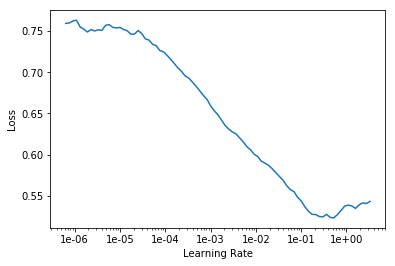

In [28]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [29]:
lr = 5e-2

In [30]:
learn.fit_one_cycle(2, max_lr=lr)

epoch,train_loss,valid_loss,accuracy
1,0.214655,0.253499,0.901736
2,0.152802,0.140027,0.949414


In [31]:
learn.save('stage-1-{0}'.format(model_name) ) #bs = 128, different images less zoom

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


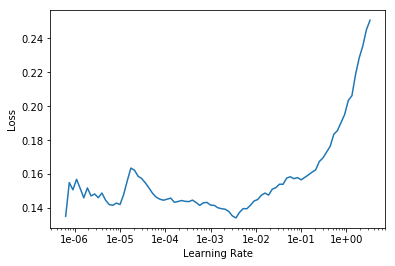

In [32]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.169129,0.148830,0.943278
2,0.150813,0.136063,0.949232
3,0.114938,0.110632,0.960231
4,0.108032,0.093869,0.967548
5,0.120052,0.088919,0.968639


In [34]:
learn.save('stage-3-{0}'.format(model_name) ) 

In [95]:
#learn.load('stage-3-{0}'.format(model_name) ) 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


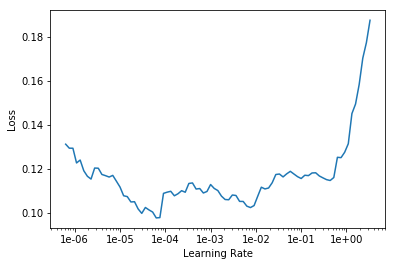

In [94]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.100790,0.088542,0.968457
2,0.086179,0.087951,0.969139
3,0.099497,0.088186,0.969185


In [96]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(8e-6, 8e-5))

epoch,train_loss,valid_loss,accuracy
1,0.102403,0.088838,0.968912
2,0.099120,0.087152,0.969730
3,0.097942,0.086547,0.970048


In [97]:
learn.save('stage-6-{0}'.format(model_name) )

In [37]:
load.save('stage-6-{0}'.format(model_name) )

In [126]:
#change batchsize
bs = 32

data =  (src.transform(tfms, size=96)
         .add_test_folder('test')
       .databunch(bs=bs)
       )

stats=data.batch_stats()        
data.normalize(stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (198023 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: ../input
x: ImageItemList (198023 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Valid: LabelList
y: CategoryList (22002 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: ../input
x: ImageItemList (22002 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Test: LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


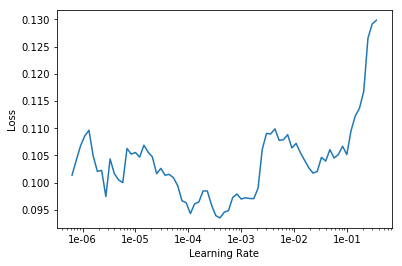

In [127]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [128]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=2e-4)

epoch,train_loss,valid_loss,accuracy
1,0.135411,0.123299,0.957458
2,0.143777,0.115571,0.958776
3,0.119907,0.117273,0.956231
4,0.109173,0.085040,0.970957
5,0.083420,0.078309,0.973230


In [129]:
learn.save('stage-7-{0}'.format(model_name) )

In [107]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-7,5e-7))

epoch,train_loss,valid_loss,accuracy
1,0.100612,0.085749,0.969957
2,0.084001,0.085600,0.969957


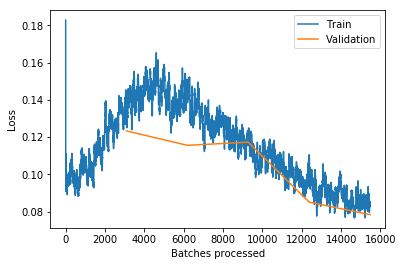

In [130]:
learn.recorder.plot_losses()

In [131]:
learn.save('final-{0}'.format(model_name) )

# Interpretation

In [132]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

## Most wrong predictions

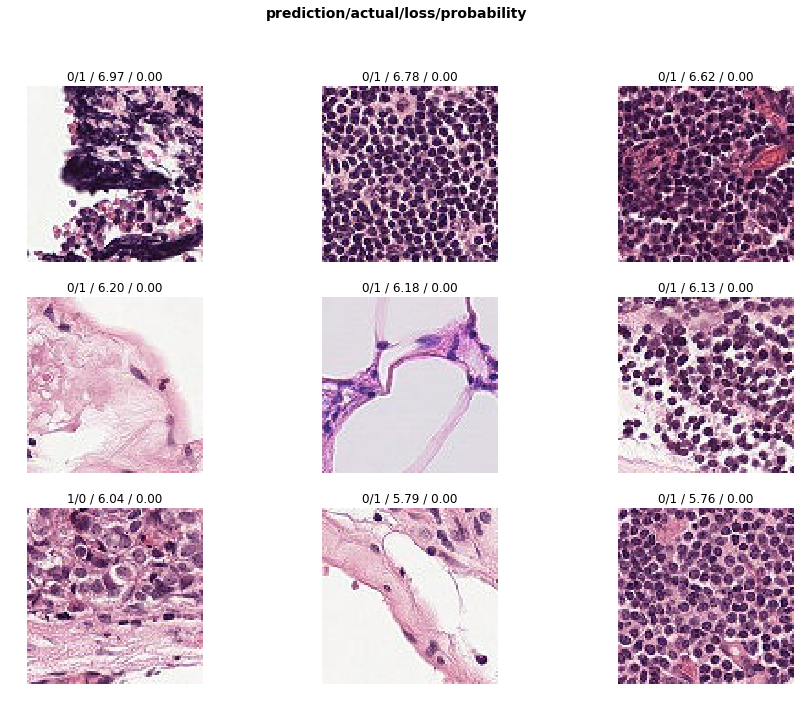

In [133]:
interp.plot_top_losses(9, figsize=(15,11))

## Confusion matrix

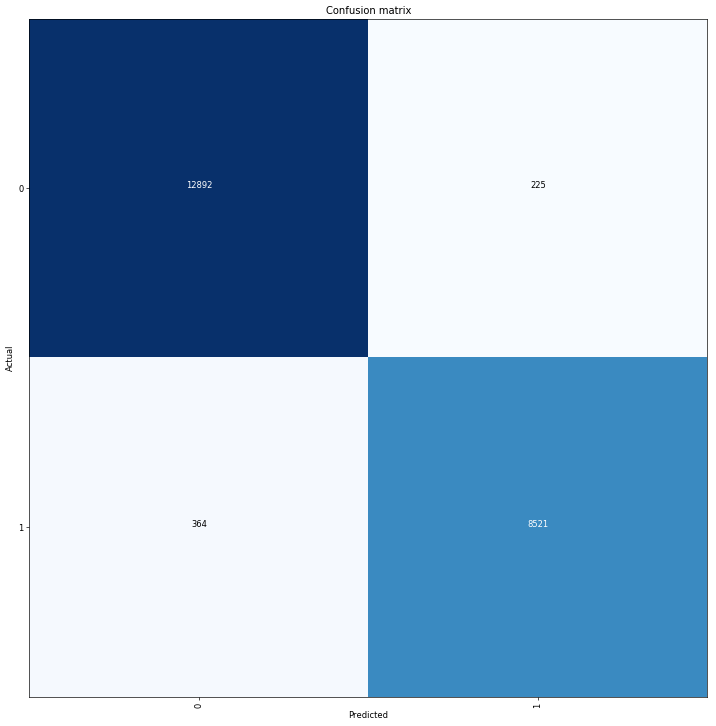

In [134]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Heatmap

In [135]:
from fastai.callbacks.hooks import *

In [50]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [51]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,96,96,0),
              interpolation='bilinear', cmap='magma');

In [52]:
m = learn.model.eval();

Category 1

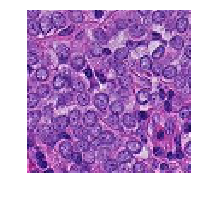

In [53]:
idx=4 #4 = category 1
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [60]:
pred_class,pred_idx,outputs = learn.predict(x)
pred_class

Category 1

In [54]:
xb,_ = data.one_item(x) #create the minibatch with one item

In [55]:
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [56]:
hook_a,hook_g = hooked_backward()


In [57]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2208, 3, 3])

In [58]:
avg_acts = acts.mean(0) #mean of the channels
avg_acts.shape

torch.Size([3, 3])

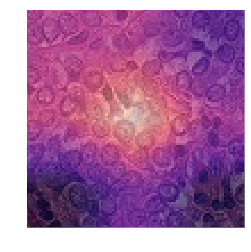

In [59]:
show_heatmap(avg_acts)

In [61]:
fn = f'{path_input}train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif'



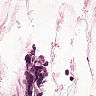

In [62]:
x = open_image(fn); x

In [63]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [68]:
pred_class,pred_idx,outputs = learn.predict(x)
pred_class

Category 0

In [64]:
hook_a,hook_g = hooked_backward()

In [65]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2208, 3, 3])

In [66]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([3, 3])

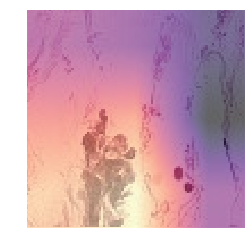

In [67]:
show_heatmap(avg_acts)

# Grad-CAM

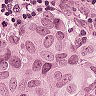

In [69]:
fn2 = f'{path_input}test/ad15cf4e12c953fd5822eec528c55a54fccaeae8.tif'
x = open_image(fn2); x

In [70]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [71]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([2208, 3, 3]), torch.Size([2208]))

In [72]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [74]:
pred_class,pred_idx,outputs = learn.predict(x)
pred_class

Category 1

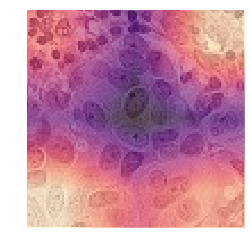

In [73]:
show_heatmap(mult)

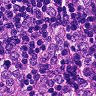

In [75]:
fn = f'{path_input}/train/0ec8c370c4f8e05a0a251d4d7c9664d2ca064fc5.tif'
x = open_image(fn); x

In [76]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [77]:
hook_a,hook_g = hooked_backward()

In [78]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

In [80]:
pred_class,pred_idx,outputs = learn.predict(x)
pred_class

Category 1

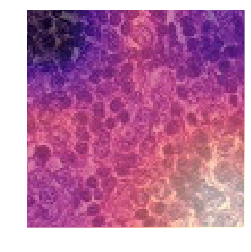

In [79]:
show_heatmap(mult)

# Predictions

In [136]:
from sklearn.metrics import *

In [137]:
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric


In [138]:
val_preds, val_labels = learn.get_preds(DatasetType.Valid)

In [139]:
pred_score = auc_score(val_preds,val_labels) 
pred_score



tensor(0.9951)

In [140]:
preds, targets = learn.get_preds(DatasetType.Test)

In [141]:
learn.data.test_ds

LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input

In [142]:
preds_tta = learn.TTA(ds_type=DatasetType.Test)[0]

In [143]:
test_y = preds_tta

In [144]:
test_y = test_y[:,1]


In [145]:
submission_df = data.test_ds.to_df()
submission_df.head()


,x,y
0,test/daaac65c384d235e976ea97d2291aace14117ca6.tif,0
1,test/304a9c4006d6a3ee6162acb78c9bc888ce011987.tif,0
2,test/11190169984dc13e3b6cea262de280355ea400b1.tif,0
3,test/56c8afa2a0e2d929611454eb930d3c5b0aa823f1.tif,0
4,test/857cb7887fdd47a4c879bf5c9204ae9aebff96fe.tif,0


In [146]:
submission_df.columns = ['id', 'label']
#submission_df['label'] = (test_y.numpy() > 0.50).astype(int)
submission_df['label'] = test_y

submission_df['id'] = submission_df['id'].apply(lambda fp: Path(fp).stem)
submission_df.head()

,id,label
0,daaac65c384d235e976ea97d2291aace14117ca6,0.477283
1,304a9c4006d6a3ee6162acb78c9bc888ce011987,0.998580
2,11190169984dc13e3b6cea262de280355ea400b1,0.112285
3,56c8afa2a0e2d929611454eb930d3c5b0aa823f1,0.184916
4,857cb7887fdd47a4c879bf5c9204ae9aebff96fe,0.004192


In [147]:
submission_df.to_csv('hc_submission.csv.gz', index=False, float_format='%.7f', compression='gzip')

In [148]:
!kaggle competitions submit -c histopathologic-cancer-detection -f hc_submission.csv.gz -m 'Submission'

100%|███████████████████████████████████████| 1.58M/1.58M [00:03<00:00, 509kB/s]
Successfully submitted to Histopathologic Cancer Detection